Step 1: Load the house size and price data from CSV and plot it

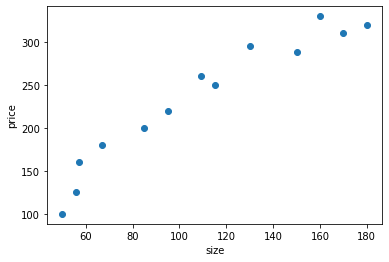

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

csv_file = get_file('house-size-price-1.csv',
                    'https://raw.githubusercontent.com/BlackLight/mlbook-code/master/datasets/house-size-price-1.csv')

with open(csv_file) as f:
    data = pd.read_csv(f)

columns = data.keys()
size = data[columns[0]]
price = data[columns[1]]

fig = plt.figure()
plot = fig.add_subplot()
plot.set_xlabel(columns[0])
plot.set_ylabel(columns[1])
points = plot.scatter(size, price)

Step 2: Get mean and standard deviation for size and price data

In [2]:
dataset_stats = data.describe()
dataset_stats

,size,price
count,13.000000,13.000000
mean,109.538462,233.692308
std,45.686642,76.123129
min,50.000000,100.000000
25%,67.000000,180.000000
50%,109.000000,250.000000
75%,150.000000,295.000000
max,180.000000,330.000000


Step 3: Normalize the data

In [3]:
def normalize(x, stats):
    return (x - stats['mean']) / stats['std']

def denormalize(x, stats):
    return stats['std'] * x + stats['mean']

In [4]:
norm_size = normalize(size, dataset_stats['size'])
norm_price = normalize(price, dataset_stats['price'])

Step 4: Define and train the linear regression model

In [1]:
from tensorflow.keras.experimental import LinearModel

model = LinearModel(1, activation='linear', dtype='float32')
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mse'])
history = model.fit(norm_size, norm_price, epochs=1000, verbose=0)

NameError: name 'norm_size' is not defined

Step 5: Plot the progress of the loss function and evaluation metrics over the training phase

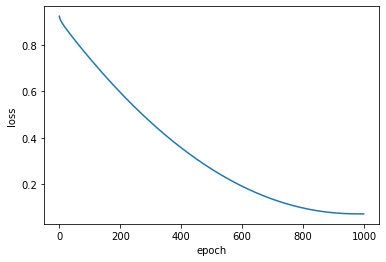

In [6]:
epochs = history.epoch
loss = history.history['loss']

fig = plt.figure()
plot = fig.add_subplot()
plot.set_xlabel('epoch')
plot.set_ylabel('loss')
plot.plot(epochs, loss)

Step 6: Evaluate the model

In [11]:
model.evaluate(norm_size, norm_price)

1/1 [==============================] - 0s 2ms/step - loss: 0.0733 - mae: 0.2395 - mse: 0.0733


[0.0733143761754036, 0.23947389423847198, 0.0733143761754036]

Step 7: Plot the linear regression line given two points against the actual dataset

In [7]:
def predict_prices(*x):
    x = normalize(x, dataset_stats['size'])
    return denormalize(model.predict(x), dataset_stats['price'])

<ipython-input-14-40455b3a3cf3>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  model_line = fig.add_subplot()


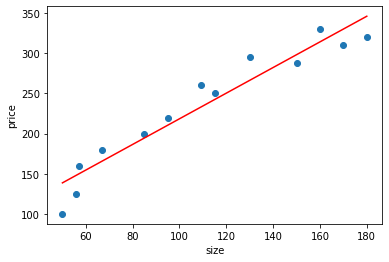

In [14]:
# Draw the linear regression model as a line between the first and
# the last element of the numeric series. x will contain the lowest
# and highest size (assumption: the series is ordered) and y will
# contain the price predictions for those inputs.
x = [size[0], size.iat[-1]]
y = [p[0] for p in predict_prices(*x)]

# Create a new figure and plot both the input data points and the
# linear model approximation.
fig = plt.figure()

data_points = fig.add_subplot()
data_points.scatter(size, price)
data_points.set_xlabel(columns[0])
data_points.set_ylabel(columns[1])

model_line = fig.add_subplot()
model_line.plot(x, y, 'r')
fig.savefig('/home/blacklight/evaluate-1.png')

In [15]:
predict_prices(90)

array([[202.5375]], dtype=float32)

Step 8: Save the model and it labels

In [23]:
def model_save(model_dir, overwrite=True):
    import json
    import os
    os.makedirs(model_dir, exist_ok=True)

    # The TensorFlow model save won't keep track of the labels of your model.
    # It's usually a good practice to store them in a separate JSON file.
    labels_file = os.path.join(model_dir, 'labels.json')
    with open(labels_file, 'w') as f:
        f.write(json.dumps(list(columns)))

    # Also, you may want to keep track of the x and y mean and
    # standard deviation to correctly normalize/de-normalize your data
    # before/after feeding it to the model.
    stats = [
        dict(dataset_stats['size']),
        dict(dataset_stats['price']),
    ]

    stats_file = os.path.join(model_dir, 'stats.json')
    with open(stats_file, 'w') as f:
        f.write(json.dumps(stats))

    # Then, save the TensorFlow model using the save primitive
    model.save(model_dir, overwrite=overwrite)


model_dir = '/home/blacklight/models/linear-regression-1'

In [24]:
model_save(model_dir)

INFO:tensorflow:Assets written to: /home/blacklight/models/linear-regression-1/assets


Step 10: Load the model

In [20]:
def model_load(model_dir):
    import json
    import os
    from tensorflow.keras.models import load_model

    labels = []
    labels_file = os.path.join(model_dir, 'labels.json')

    if os.path.isfile(labels_file):
        with open(labels_file) as f:
            labels = json.load(f)

    stats = []
    stats_file = os.path.join(model_dir, 'stats.json')

    if os.path.isfile(stats_file):
        with open(stats_file) as f:
            stats = json.load(f)

    m = load_model(model_dir)
    return m, stats, labels

In [25]:
model, stats, labels = model_load(model_dir)

In [27]:
size = 90
price = predict_prices(size)
print(price)

[[202.5375]]


In [24]:
import numpy as np

def gradient_descent(x, y, theta, alpha):
    m = len(x)
    n = len(theta)
    new_theta = np.zeros(n)

    # Perform the gradient descent on theta
    for i in range(m):
        # Calculate s = (theta[0]*x[0] + theta[1]*x[1] + ...
        #              + theta[n]*x[n]) - y[i]
        s = theta[0]
        for j in range(1, n):
            s += theta[j]*x[i][j-1]
        s -= y[i]

        new_theta[0] += s
        for j in range(1, n):
            new_theta[j] += s * x[i][j-1]

    return theta - (alpha/m) * new_theta

def train(x, y, steps, alpha=0.001):
    # Initialize theta randomly
    theta = np.random.randint(low=0, high=10, size=len(x[0])+1)

    # Perform the gradient descent <steps> times
    for i in range(steps):
        theta = gradient_descent(x, y, theta, alpha)

    # Return the linear function associated to theta
    def model(x):
        y = theta[0]
        for i in range(len(theta)-1):
            y += theta[i+1] * x[i]
        return y

    return model

print(norm_size.size)
m = train([[s] for s in norm_size], norm_price, 5000)
x = normalize([[90]], dataset_stats['size'])
p = m(x)
p = denormalize(p, dataset_stats['price'])
print(p)

13
[206.08382401]


array([1., 2., 3.])